In [3]:
!pip install itkwidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 19.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 14.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 MB 13.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import nibabel as nib                                                     
import itk                                                                
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
from datetime import datetime
%matplotlib inline
import seaborn as sns
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

In [5]:
import tarfile
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./brain_images')
file.close()

In [6]:
image_path = "./brain_images/BraTS2021_00284/BraTS2021_00284_t1.nii.gz"
image_obj = nib.load(image_path)
type(image_obj)

nibabel.nifti1.Nifti1Image

In [7]:
image_data = image_obj.get_fdata()
print(type(image_data))
image_data.shape

<class 'numpy.ndarray'>


(240, 240, 155)

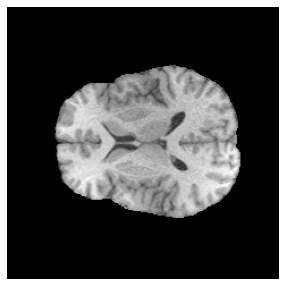

77

In [8]:
def visualize_3d(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.axis('off')
    return layer

interact(visualize_3d, layer=(0, image_data.shape[2] - 1));

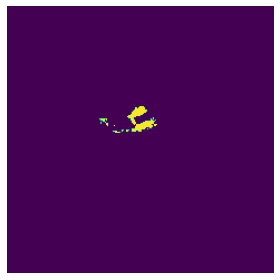

In [9]:
layer = 50
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}

def visualize_3d_labels(layer):
    mask = nib.load('./brain_images/BraTS2021_00284/BraTS2021_00284_seg.nii.gz').get_fdata()
    plt.imshow(mask[:,:,layer])
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(0, image_data.shape[2] - 1));

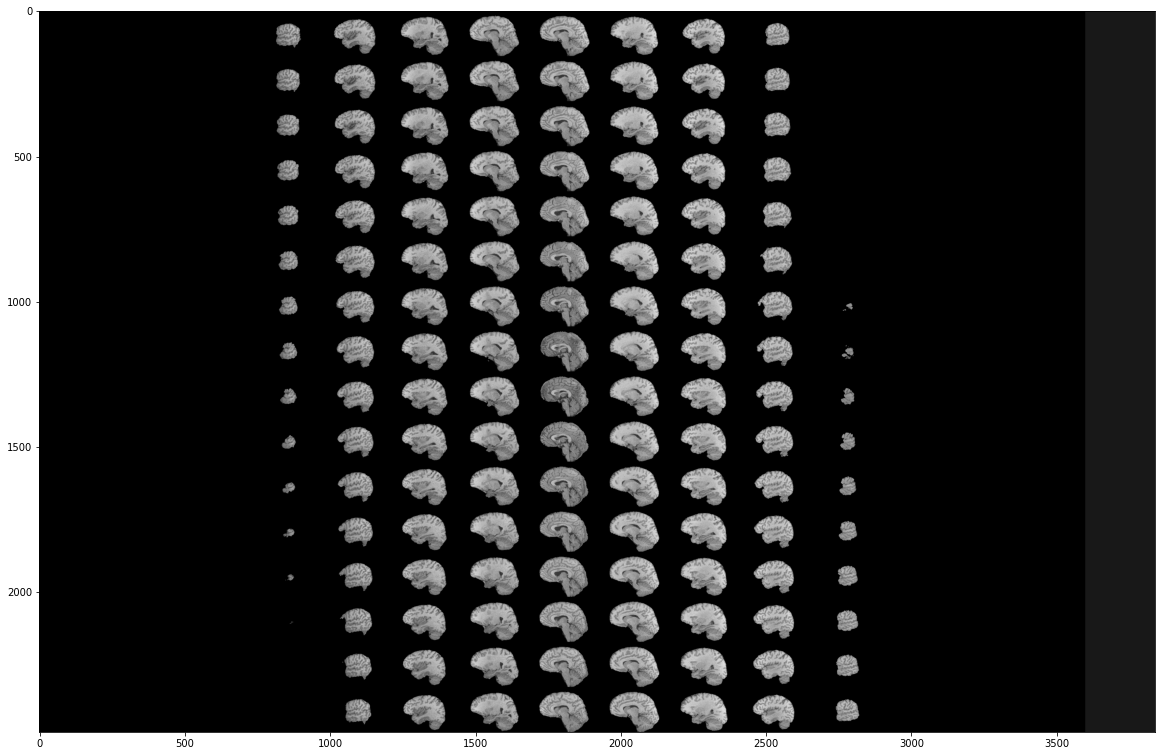

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(image_data[:,:,:]), 90, resize=True), cmap ='gray')

In [11]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [12]:
IMG_SIZE=128

In [13]:
TRAIN_DATASET_PATH = './brain_images'

file = tarfile.open('../input/brats-2021-task1/BraTS2021_00621.tar')
file.extractall('./val_brain_images')
file.close()

In [14]:
VALIDATION_DATASET_PATH = '../val_brain_images'

In [15]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [16]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [17]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 128 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [18]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
             
             
             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        X = X.reshape(1,128,128,128,2)
        y = y.reshape(1,128,128,128)
        # Generate masks
        y[y==4] = 3;
        y = tf.one_hot(y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        #Y = np.array(Y).reshape(1,128,128,128)
        return X/np.max(X), y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [19]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),
      csv_logger
    ]

In [20]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
    
  X = add([input_mat,X]);
  
  return X


def Vnet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  #c1 = conv_block(input_img,n_filters,3,batch_norm)
  c1 = Conv3D(n_filters,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
  #c1 = add([c1,input_img])
  
  c2 = Conv3D(n_filters*2,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(c1)
  
  c3 = conv_block(c2 , n_filters*2,5,True)
  
  p3 = Conv3D(n_filters*4,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3, n_filters*4,5,True)
  p4 = Conv3D(n_filters*8,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c4)
  p4 = Dropout(dropout)(p4)
    
  c5 = conv_block(p4, n_filters*8,5,True)
  p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c5)
  p6 = Dropout(dropout)(p6)
  #c6 = conv_block(p5, n_filters*8,5,True)
  #p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c6)

  p7 = conv_block(p6,n_filters*16,5,True)
    
  u6 = Conv3DTranspose(n_filters*8, (2,2,2), strides=(2, 2, 2), padding='same')(p7);
  u6 = concatenate([u6,c5]);
  c7 = conv_block(u6,n_filters*16,5,True)
  c7 = Dropout(dropout)(c7)
  u7 = Conv3DTranspose(n_filters*4,(2,2,2),strides = (2,2,2) , padding= 'same')(c7);

  
  u8 = concatenate([u7,c4]);
  c8 = conv_block(u8,n_filters*8,5,True)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters*2,(2,2,2),strides = (2,2,2) , padding= 'same')(c8);
    
  u9 = concatenate([u9,c3]);
  c9 = conv_block(u9,n_filters*4,5,True)
  c9 = Dropout(dropout)(c9)
  u10 = Conv3DTranspose(n_filters,(2,2,2),strides = (2,2,2) , padding= 'same')(c9);
  
  
  u10 = concatenate([u10,c1]);
  c10 = Conv3D(n_filters*2,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(u10);
  c10 = Dropout(dropout)(c10)
  c10 = add([c10,u10]);
  
  

  #c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1,1,1), activation='softmax')(c10)

  model = Model(inputs=input_img, outputs=outputs)
  #model2 = Model(inputs=input_img, outputs=c10)

  return model

In [21]:
input_layer = Input((128,IMG_SIZE, IMG_SIZE, 2))

model1 = Vnet_3d(input_layer)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )

model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 2008        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 64, 64, 1 1040        conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 64, 64, 1 32016       conv3d_1[0][0]                   
______________________________________________________________________________________________

In [27]:
history =  model1.fit(training_generator,
                     epochs=5,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model1.save("model_vnet_2mod.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 1/5
850/850 [==============================] - 845s 994ms/step - loss: 0.0321 - accuracy: 0.9905 - mean_io_u: 0.4060 - dice_coef: 0.5241 - precision: 0.9934 - sensitivity: 0.9880 - specificity: 0.9978 - dice_coef_necrotic: 0.2094 - dice_coef_edema: 0.4822 - dice_coef_enhancing: 0.4073 - val_loss: 0.1902 - val_accuracy: 0.9607 - val_mean_io_u: 0.3752 - val_dice_coef: 0.4005 - val_precision: 0.9741 - val_sensitivity: 0.9557 - val_specificity: 0.9918 - val_dice_coef_necrotic: 0.1025 - val_dice_coef_edema: 0.2564 - val_dice_coef_enhancing: 0.2619
Epoch 2/5
850/850 [==============================] - 847s 996ms/step - loss: 0.0263 - accuracy: 0.9917 - mean_io_u: 0.4040 - dice_coef: 0.5729 - precision: 0.9942 - sensitivity: 0.9896 - specificity: 0.9981 - dice_coef_necrotic: 0.2330 - dice_coef_edema: 0.5606 - dice_coef_enhancing: 0.5003 - val_loss: 0.3667 - val_accuracy: 0.9436 - val_mean_io_u: 0.3752 - val_dice_coef: 0.4149 - val_precision: 0.9584 - val_sensitivity: 0.9393 - val_specifi

In [28]:
model = keras.models.load_model('./model_vnet_2mod.h5', custom_objects={
    "dice_coef":dice_coef,
    "precision":precision,
    "sensitivity":sensitivity,
    "specificity":specificity,
    "dice_coef_necrotic":dice_coef_necrotic,
    "dice_coef_edema":dice_coef_edema,
    "dice_coef_enhancing":dice_coef_enhancing
    })

In [29]:
callbacks=[]
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
callbacks.append(tensorboard_callback)

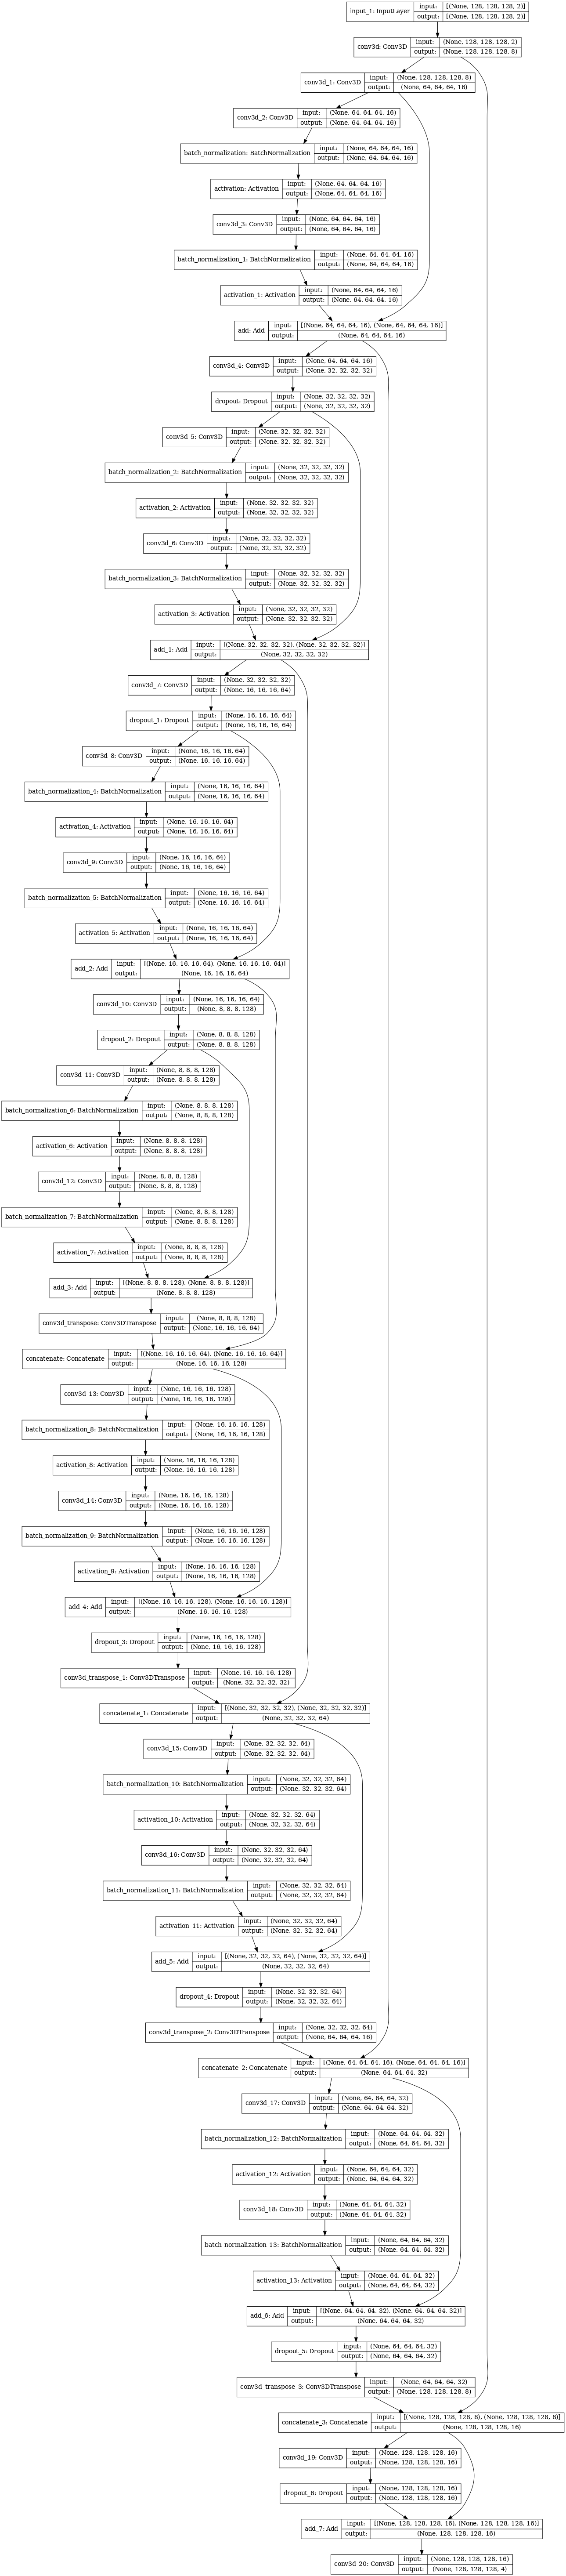

In [31]:
plot_model(model1, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

UNET

In [1]:
import os
import time
import subprocess
import random
import zipfile
import nibabel as nib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import cv2
from skimage.util import montage
from skimage.transform import rotate
from sklearn.model_selection import train_test_split

import keras
import tensorflow
import keras.backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import *
from tensorflow.keras.models import *


import os
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Uncompress function (already provided)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:
def uncompress_function(tarfile, extract_dir):
    start = time.time()
    subprocess.run(["rm", "-rf", extract_dir])
    subprocess.run(["mkdir", "-p", extract_dir])
    subprocess.run(["tar", "-xf", tarfile, "-C", extract_dir])
    end = time.time()
    print(f"Uncompress Dataset time: {(end - start):.2f}")
COMPRESS_FILE = True
if COMPRESS_FILE:
    uncompress_function("/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar", "/kaggle/working/data/BraTS2021_train")

Uncompress Dataset time: 145.86


In [5]:
import os
import numpy as np
import nibabel as nib
import cv2
import psutil  # For monitoring system memory usage

# Paths to the data
data_dir = "/kaggle/working/data/BraTS2021_train/"

# Memory limit in bytes (15GB)
MEMORY_LIMIT = 5 * 1024 * 1024 * 1024

def load_nifti_image(file_path):
    """
    Load NIfTI file using nibabel.
    """
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

def load_mri_images_and_masks(data_dir):
    """
    Load MRI images and corresponding segmentation masks from BraTS dataset 
    while ensuring RAM usage does not exceed 15GB.
    """
    images = []
    masks = []
    
    for patient_dir in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_dir)
        if os.path.isdir(patient_path):
            # Load the FLAIR MRI image (you can change this to T1, T2, etc.)
            flair_image_path = os.path.join(patient_path, patient_dir + "_flair.nii.gz")
            flair_image = load_nifti_image(flair_image_path)
            
            # Load the segmentation mask
            mask_image_path = os.path.join(patient_path, patient_dir + "_seg.nii.gz")
            mask_image = load_nifti_image(mask_image_path)
            
            # Loop through slices in the 3rd dimension (z-axis)
            for i in range(flair_image.shape[2]):
                # Resize the image and mask slices to 128x128
                image_slice = cv2.resize(flair_image[:, :, i], (128, 128))
                mask_slice = cv2.resize(mask_image[:, :, i], (128, 128), interpolation=cv2.INTER_NEAREST)
                
                images.append(image_slice)
                masks.append(mask_slice)
                
                # Check if the current memory usage exceeds the limit
                current_memory = psutil.virtual_memory().used
                if current_memory > MEMORY_LIMIT:
                    print(f"Memory limit reached: Stopping the loading of images.")
                    return np.array(images).astype(np.float32), np.array(masks).astype(np.float32)
    
    images = np.array(images).astype(np.float32)
    masks = np.array(masks).astype(np.float32)
    
    # Normalize the images to [0, 1]
    images = images / np.max(images)
    
    # Binarize the masks (focusing on tumor vs. non-tumor)
    masks = np.where(masks > 0, 1, 0)
    
    return images, masks

In [6]:
X, Y = load_mri_images_and_masks(data_dir)

Memory limit reached: Stopping the loading of images.


In [7]:
# Step 3: Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
# Add an extra dimension for the model (channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
Y_train = Y_train[..., np.newaxis]
Y_val = Y_val[..., np.newaxis]

In [9]:


# Step 2: Load and preprocess data


# Step 4: Define the U-Net model
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Contracting Path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Expanding Path
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Step 5: Compile the model


In [10]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train the model

In [11]:
history = model.fit(X_train, Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=5, batch_size=16)

Epoch 1/5
812/812 [==============================] - 188s 213ms/step - loss: 0.3691 - accuracy: 0.9786 - val_loss: 0.0568 - val_accuracy: 0.9807
Epoch 2/5
812/812 [==============================] - 174s 215ms/step - loss: 0.0529 - accuracy: 0.9871 - val_loss: 0.0397 - val_accuracy: 0.9892
Epoch 3/5
812/812 [==============================] - 174s 215ms/step - loss: 0.0109 - accuracy: 0.9849 - val_loss: -0.0212 - val_accuracy: 0.9838
Epoch 4/5
812/812 [==============================] - 171s 210ms/step - loss: 56.0676 - accuracy: 0.9398 - val_loss: 0.3596 - val_accuracy: 0.9892
Epoch 5/5
812/812 [==============================] - 168s 207ms/step - loss: 0.2777 - accuracy: 0.9895 - val_loss: 0.2223 - val_accuracy: 0.9892


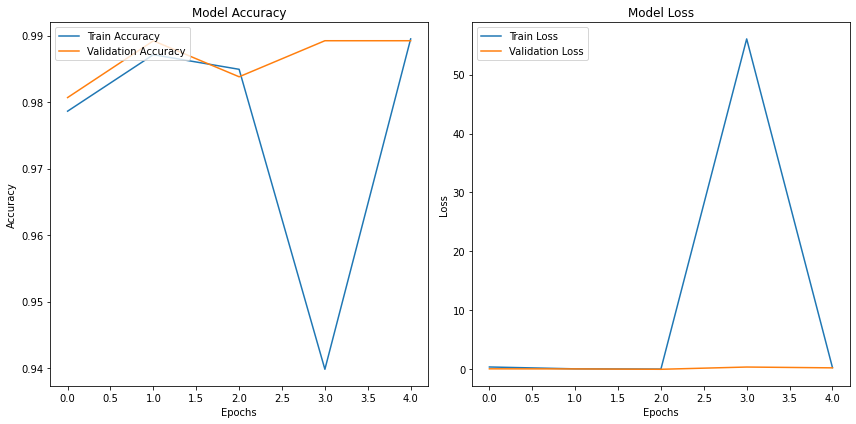

In [13]:
import matplotlib.pyplot as plt

# Step 7: Plot accuracy and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [21]:
print(Y_train.shape)  # Should be (batch_size, 128, 128, 1)


(12992, 128, 128, 1)
